In [1]:
import numpy as np 
import pandas as pd
import os
from matplotlib import pyplot as plt

# Reading the data and storing it into a dictionary

In [2]:
root='D:\Raya\Machine_Learning_Course\Resume classyfy'
data={}
for i in os.listdir(root):
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i

# Converting data dictionary to pandas dataframe

In [3]:
data=pd.DataFrame(data.items(),columns=['file','type'])
data.head()

,file,type
0,/kaggle/input/resume-dataset/data/data/DESIGNE...,DESIGNER
1,/kaggle/input/resume-dataset/data/data/DESIGNE...,DESIGNER
2,/kaggle/input/resume-dataset/data/data/DESIGNE...,DESIGNER
3,/kaggle/input/resume-dataset/data/data/DESIGNE...,DESIGNER
4,/kaggle/input/resume-dataset/data/data/DESIGNE...,DESIGNER


# Data Distribution Visualization

<Axes: >

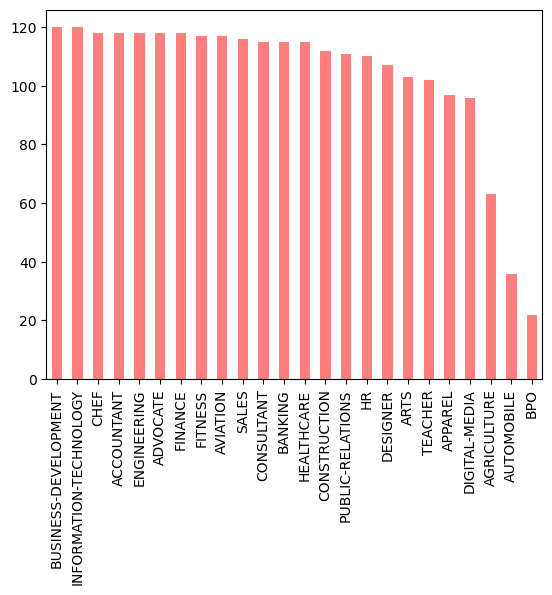

In [4]:
count_=data['type'].value_counts()
count_.plot(kind='bar', color='r', alpha=.5)

# Reading Data from PDF Files

In [5]:
! pip install tika
from tika import parser 

  Preparing metadata (setup.py) ... - \ done
  Created wheel for tika: filename=tika-2.6.0-py3-none-any.whl size=32642 sha256=0aeee112106e9d30babb383c083e8609fa666cf80374d5c28d1616c266ea49a5
  Stored in directory: /root/.cache/pip/wheels/5f/71/c7/b757709531121b1700cffda5b6b0d4aad095fb507ec84316d0
Successfully built tika


In [6]:
texts_cv=[]
empty_cv=[]
for i in range(len(data)):
    raw = parser.from_file(data.iloc[i]['file'])
    try:
        texts_cv.append(raw['content'].replace('\n',' '))
    except:
        texts_cv.append('')
        empty_cv.append(i)
        

2023-08-11 01:14:59,308 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar to /tmp/tika-server.jar.
2023-08-11 01:14:59,809 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar.md5 to /tmp/tika-server.jar.md5.
2023-08-11 01:15:00,137 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


In [7]:
texts_cv[0] # sample cv text

'                                PRE-PRESS GRAPHIC DESIGNER Summary Creative, hardworking designer seeking a full-time desktop job, educated as a graphic artist, past experience in business world as a desktop publisher laying out designs for printed mail and advertisements, in local government designing new websites with graphics for different agencies within the system, and later for the same government printing and reproduction center creating documents to be printed off a press or copiers. Skills  Adobe InDesign, Photoshop, Illustrator, and Acrobat Professional Strongly familiar with Microsoft Word, Excel, PowerPoint, and Publisher / also QuarkXPress Basic knowledge of web development with Adobe Dreamweaver, HTML, WordPress Able to perform graphic design and administrative functions Able to work as a team player and independently Experienced using phone, fax, email, copiers and printers Provides excellent customer service (in-person, by phone, email, or interoffice mail) Prioritizes

In [8]:
len(empty_cv)

1

In [9]:
data['text']=texts_cv

# Dropping Empty CV

In [10]:
data=data.drop(empty_cv)

# EDA on CV Content

In [11]:
cv_length=[len(i) for i in texts_cv]

Text(0.5, 1.0, 'CV length')

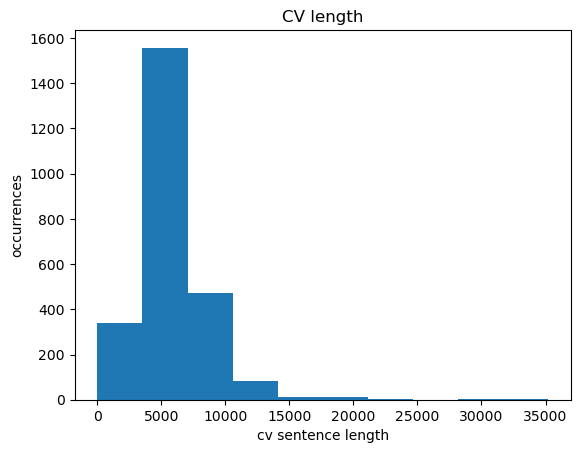

In [12]:
plt.hist(cv_length)
plt.xlabel('cv sentence length')
plt.ylabel('occurrences')
plt.title('CV length')

In [13]:
import statistics
mean = sum(cv_length) / len(cv_length) #mean
std = statistics.pstdev(cv_length) #Standard deviation
mean,std

(5993.578904991949, 2632.9068231874835)

# Out of the range of (Mean +- 3*std) is considered outlier

In [14]:
vocab_size= int(mean+ (3*std))
vocab_size

13892

# Data Splitting

In [15]:
def split_data(data,ratio):
    last=int(len(data)*ratio)
    return data[:last], data[last:]

data=data.sample(frac=1)
train,test=split_data(data,.8)
validation,train=split_data(data,.08)
# train:validation:test=70:10:20

## Making sure each subset has all the classes

In [16]:
print(len(train["type"].value_counts()))
print(len(test["type"].value_counts()))
print(len(validation["type"].value_counts()))

24
24
24


In [17]:
X_train=train['text']
X_test=test['text']
X_validation=validation['text']

y_train=train['type']
y_test=test['type']
y_validation=validation['type']

# Traditional ML models on raw data

## First Try with TF-IDF vectorizer

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer #Term Frequency Inverse Document Frequency
vectorizer = TfidfVectorizer(ngram_range=(1,5),max_features=vocab_size)
X_train_tfidf = vectorizer.fit_transform(X_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
X_validation_tfidf=vectorizer.transform(X_validation)

In [20]:
from sklearn import metrics
def score_prediction(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    pr = model.predict(X_test)
    acc_score = metrics.accuracy_score(y_test,pr)
    pre_score = metrics.precision_score(y_test,pr,average="weighted")
    recall= metrics.recall_score(y_test,pr,average="weighted")
    f1= metrics.f1_score(y_test,pr,average="weighted")
    mcc= metrics.matthews_corrcoef(y_test,pr)
    return acc_score,pre_score,recall,f1,mcc
acc_score = {}
pre_score = {}
recall_score={}
f1_score={}
mcc_score={}

In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier


lg = LogisticRegression(penalty='l1',solver='liblinear')
sv = SVC(kernel='sigmoid',gamma=1.0)
dtc = DecisionTreeClassifier(max_depth=5)
knn = KNeighborsClassifier()
rfc = RandomForestClassifier(n_estimators=50,random_state=2)
etc = ExtraTreesClassifier(n_estimators=50,random_state=2)
bg = BaggingClassifier(n_estimators=50,random_state=2)
gbc = GradientBoostingClassifier(n_estimators=50,random_state=2)


clfs= {
    'LR':lg,
    'SVM':sv,
    'DTC':dtc,
    'KNN':knn,
    'RFC':rfc,
    'ETC':etc,
    'BG':bg,
    'GBC':gbc,
}
for name,clf in clfs.items():
    acc_score[name],pre_score[name],recall_score[name],f1_score[name],mcc_score[name] = score_prediction(clf,X_train_tfidf,X_validation_tfidf,y_train,y_validation)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

## Result Analysis

In [22]:
acc_score

{'LR': 0.7474747474747475,
 'SVM': 0.6666666666666666,
 'DTC': 0.23737373737373738,
 'KNN': 0.5151515151515151,
 'RFC': 0.6868686868686869,
 'ETC': 0.6919191919191919,
 'BG': 0.7575757575757576,
 'GBC': 0.7777777777777778}

In [23]:
pre_score

{'LR': 0.7778773695440362,
 'SVM': 0.71856587823611,
 'DTC': 0.21744442726585586,
 'KNN': 0.598356538819997,
 'RFC': 0.6768247605368819,
 'ETC': 0.6924306976446014,
 'BG': 0.7847048784548786,
 'GBC': 0.8086179252845919}

In [24]:
recall_score

{'LR': 0.7474747474747475,
 'SVM': 0.6666666666666666,
 'DTC': 0.23737373737373738,
 'KNN': 0.5151515151515151,
 'RFC': 0.6868686868686869,
 'ETC': 0.6919191919191919,
 'BG': 0.7575757575757576,
 'GBC': 0.7777777777777778}

In [25]:
f1_score

{'LR': 0.7382098870839827,
 'SVM': 0.6689501252785617,
 'DTC': 0.21350295522006107,
 'KNN': 0.5360545006076408,
 'RFC': 0.6573174658095645,
 'ETC': 0.6688448365172501,
 'BG': 0.7516262902732003,
 'GBC': 0.7780927110999575}

In [26]:
mcc_score

{'LR': 0.7373910180555264,
 'SVM': 0.6523392993071399,
 'DTC': 0.3186725614808342,
 'KNN': 0.4954611170365433,
 'RFC': 0.6735107259450018,
 'ETC': 0.6793131521987843,
 'BG': 0.7474804046990834,
 'GBC': 0.7689360781939663}

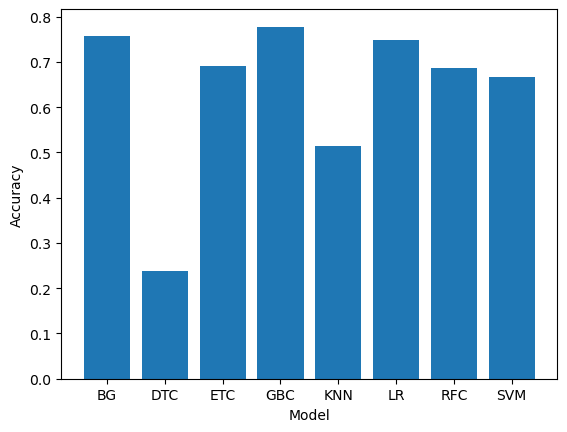

In [27]:
lists = sorted(acc_score.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar( x, y)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

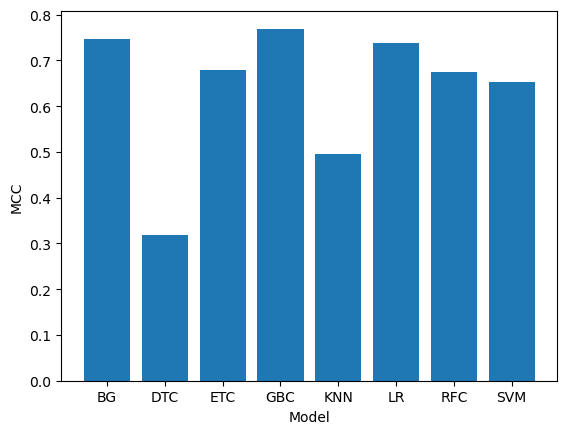

In [28]:
lists = sorted(mcc_score.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar( x, y)
plt.xlabel('Model')
plt.ylabel('MCC')
plt.show()

## Gradient Boosting is the best ml model for this problem

# Experiment with data cleaning

## Delete Stop words

In [29]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1,5),max_features=vocab_size,stop_words=stopwords.words('english'))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_validation_tfidf=vectorizer.transform(X_validation)

## Since Gradient Boosting had the heighest performance

In [31]:
score_prediction(gbc,X_train_tfidf,X_validation_tfidf,y_train,y_validation)

(0.7828282828282829,
 0.8147502196545258,
 0.7828282828282829,
 0.7850068192132054,
 0.7741484714674419)

## Deleting stop words upgraded the performance

# Keep Alphabetic Characters Only

In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1,5),max_features=vocab_size,stop_words=stopwords.words('english'),token_pattern=r'(?u)\b[A-Za-z]+\b')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_validation_tfidf=vectorizer.transform(X_validation)

In [33]:
score_prediction(gbc,X_train_tfidf,X_validation_tfidf,y_train,y_validation)

(0.7626262626262627,
 0.7935477821841458,
 0.7626262626262627,
 0.7661669336382783,
 0.7531326096849281)

## This made the performance worse

# Bag-of-words

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,5),max_features=vocab_size,stop_words=stopwords.words('english'))
X_train_bow = vectorizer.fit_transform(X_train)
X_validation_bow=vectorizer.transform(X_validation)

In [35]:
score_prediction(gbc,X_train_bow,X_validation_bow,y_train,y_validation)

(0.797979797979798,
 0.8291834848653031,
 0.797979797979798,
 0.7982568323440703,
 0.7898979689984903)

## TF-IDF is slightly better than BoW

# Try Deep Learning

## We will continue with the best configeration that is TF-IDF with deleting stop words

In [36]:
vectorizer = TfidfVectorizer(ngram_range=(1,5),max_features=vocab_size,stop_words=stopwords.words('english'))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_validation_tfidf=vectorizer.transform(X_validation)

X_train_tfidf_arr=X_train_tfidf.toarray()
y_train_ohe= pd.get_dummies(y_train).values

X_validation_tfidf_arr=X_validation_tfidf.toarray()
y_validation_ohe= pd.get_dummies(y_validation).values

In [37]:
input_sp=len(X_train_tfidf_arr[0])
out_sp=len(y_validation_ohe[0])

## Multi-layer Perceptron

In [38]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM
from sklearn import metrics
model = Sequential()
model.add(Dense(2048,input_shape = (input_sp,), activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(out_sp,activation='softmax'))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [39]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy',])
history= model.fit(X_train_tfidf_arr, y_train_ohe, epochs=50, batch_size=128,verbose=2)

Epoch 1/50
18/18 - 6s - loss: 3.1693 - accuracy: 0.0420 - 6s/epoch - 342ms/step
Epoch 2/50
18/18 - 0s - loss: 3.0874 - accuracy: 0.0998 - 217ms/epoch - 12ms/step
Epoch 3/50
18/18 - 0s - loss: 2.7739 - accuracy: 0.2053 - 200ms/epoch - 11ms/step
Epoch 4/50
18/18 - 0s - loss: 2.1770 - accuracy: 0.3510 - 197ms/epoch - 11ms/step
Epoch 5/50
18/18 - 0s - loss: 1.5977 - accuracy: 0.5291 - 198ms/epoch - 11ms/step
Epoch 6/50
18/18 - 0s - loss: 1.2777 - accuracy: 0.6232 - 194ms/epoch - 11ms/step
Epoch 7/50
18/18 - 0s - loss: 0.8985 - accuracy: 0.7243 - 198ms/epoch - 11ms/step
Epoch 8/50
18/18 - 0s - loss: 0.4591 - accuracy: 0.8613 - 195ms/epoch - 11ms/step
Epoch 9/50
18/18 - 0s - loss: 0.3481 - accuracy: 0.9007 - 198ms/epoch - 11ms/step
Epoch 10/50
18/18 - 0s - loss: 0.4123 - accuracy: 0.9365 - 204ms/epoch - 11ms/step
Epoch 11/50
18/18 - 0s - loss: 0.2277 - accuracy: 0.9374 - 196ms/epoch - 11ms/step
Epoch 12/50
18/18 - 0s - loss: 0.0145 - accuracy: 0.9982 - 198ms/epoch - 11ms/step
Epoch 13/50
18/

/tmp/ipykernel_22/884132123.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax[0].plot(epochs , train_acc , 'go-' ,color='r', label = 'Training Accuracy')
/tmp/ipykernel_22/884132123.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.
  ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')


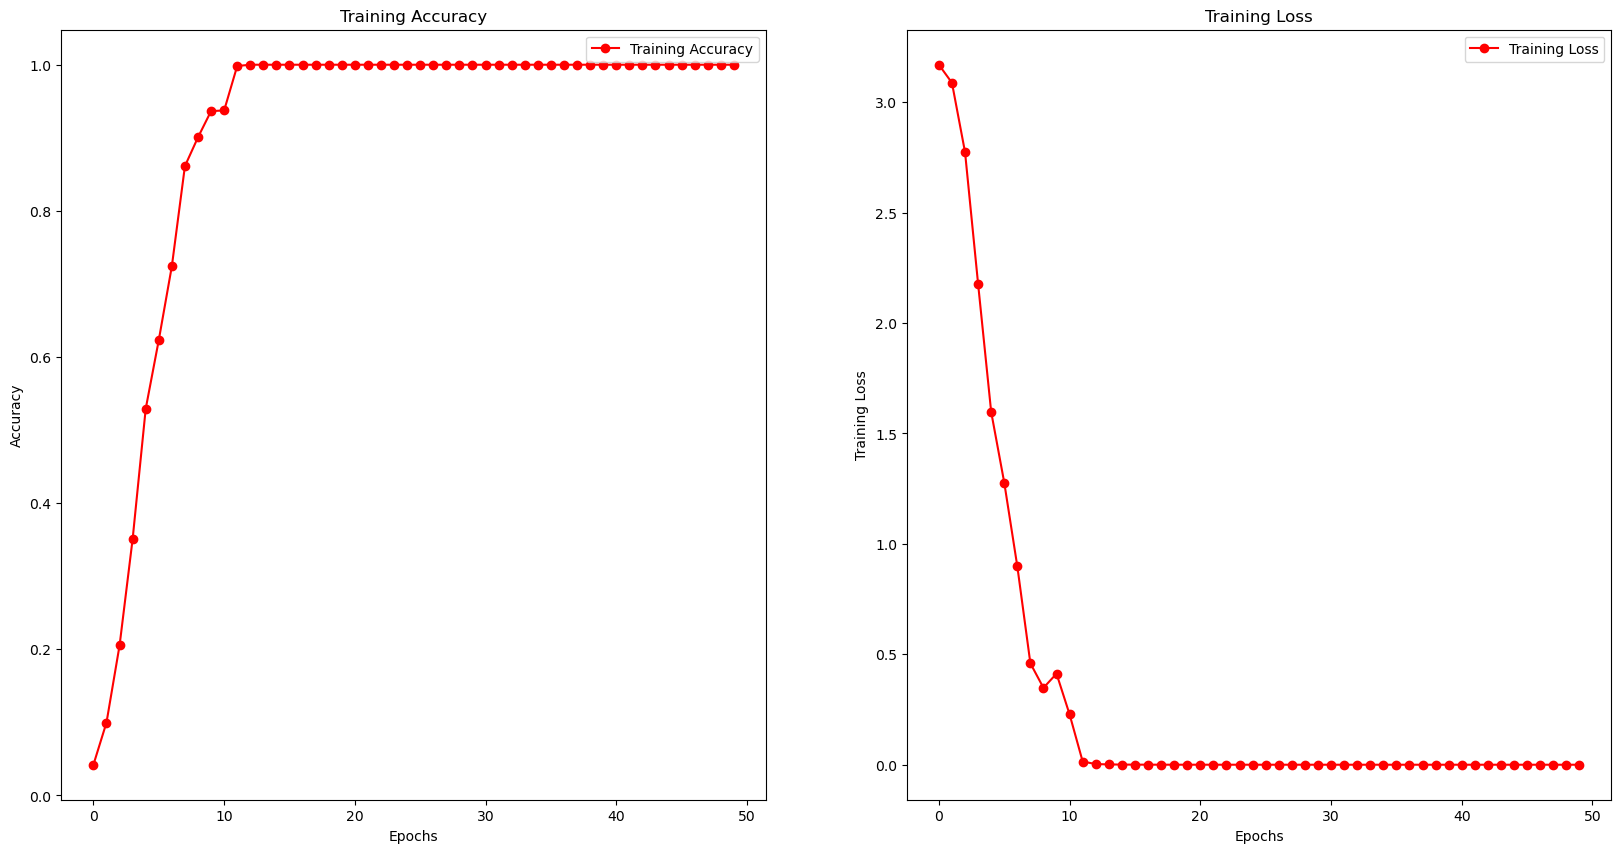

In [40]:
epochs = list(range(len(history.history['accuracy'])))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']


fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' ,color='r', label = 'Training Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

In [41]:
proba=model.predict(X_validation_tfidf_arr)
pr = np.argmax(proba,axis=1)
true=np.argmax(y_validation_ohe,axis=1)

acc_score = metrics.accuracy_score(true,pr)
pre_score = metrics.precision_score(true,pr,average="weighted")
recall= metrics.recall_score(true,pr,average="weighted")
f1= metrics.f1_score(true,pr,average="weighted")
mcc= metrics.matthews_corrcoef(true,pr)
acc_score,pre_score,recall,f1,mcc

7/7 [==============================] - 0s 4ms/step


(0.6616161616161617,
 0.6994671574217027,
 0.6616161616161617,
 0.667751892535623,
 0.6463545293834039)

## Model overfitted. Adding Dropout

In [42]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Dense(2048,input_shape = (input_sp,), activation = 'relu'))
model.add(Dropout(.5))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(.4))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(.3))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(out_sp,activation='softmax'))

In [43]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy',])
history= model.fit(X_train_tfidf_arr, y_train_ohe, epochs=50, batch_size=128,verbose=2)

Epoch 1/50
18/18 - 2s - loss: 3.1706 - accuracy: 0.0455 - 2s/epoch - 134ms/step
Epoch 2/50
18/18 - 0s - loss: 3.1460 - accuracy: 0.0534 - 230ms/epoch - 13ms/step
Epoch 3/50
18/18 - 0s - loss: 3.0291 - accuracy: 0.0963 - 204ms/epoch - 11ms/step
Epoch 4/50
18/18 - 0s - loss: 2.7259 - accuracy: 0.1554 - 205ms/epoch - 11ms/step
Epoch 5/50
18/18 - 0s - loss: 2.4313 - accuracy: 0.2556 - 205ms/epoch - 11ms/step
Epoch 6/50
18/18 - 0s - loss: 2.0559 - accuracy: 0.3698 - 202ms/epoch - 11ms/step
Epoch 7/50
18/18 - 0s - loss: 1.6759 - accuracy: 0.4718 - 205ms/epoch - 11ms/step
Epoch 8/50
18/18 - 0s - loss: 1.2572 - accuracy: 0.5969 - 203ms/epoch - 11ms/step
Epoch 9/50
18/18 - 0s - loss: 0.9520 - accuracy: 0.6941 - 209ms/epoch - 12ms/step
Epoch 10/50
18/18 - 0s - loss: 0.7236 - accuracy: 0.7659 - 200ms/epoch - 11ms/step
Epoch 11/50
18/18 - 0s - loss: 0.7238 - accuracy: 0.7847 - 199ms/epoch - 11ms/step
Epoch 12/50
18/18 - 0s - loss: 0.3234 - accuracy: 0.9020 - 198ms/epoch - 11ms/step
Epoch 13/50
18/

In [44]:
proba=model.predict(X_validation_tfidf_arr)
pr = np.argmax(proba,axis=1)
true=np.argmax(y_validation_ohe,axis=1)

acc_score = metrics.accuracy_score(true,pr)
pre_score = metrics.precision_score(true,pr,average="weighted")
recall= metrics.recall_score(true,pr,average="weighted")
f1= metrics.f1_score(true,pr,average="weighted")
mcc= metrics.matthews_corrcoef(true,pr)
acc_score,pre_score,recall,f1,mcc

7/7 [==============================] - 0s 3ms/step


(0.6565656565656566,
 0.6928075011408344,
 0.6565656565656566,
 0.6560138513673389,
 0.6416875599411289)

## MLP Didn't work

# Bi-LSTM

In [45]:
# Functional API
from tensorflow.keras import models, layers, optimizers
input_ = layers.Input(shape =(input_sp,),name='input')
x=layers.Reshape((input_sp, 1), input_shape = (input_sp, ))(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2, return_sequences=False),name='bidirectional-lstm')(x) 
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(out_sp,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01) # because bi-lstms are slow, cannot affort high epoch, therefore higher learning rate for faster convergence 
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history= model.fit(X_train_tfidf_arr, y_train_ohe, epochs=50, batch_size=128,verbose=2)

Epoch 1/50
18/18 - 18s - loss: 3.1638 - accuracy: 0.0446 - 18s/epoch - 1s/step
Epoch 2/50
18/18 - 11s - loss: 3.1470 - accuracy: 0.0516 - 11s/epoch - 613ms/step
Epoch 3/50
18/18 - 11s - loss: 3.1417 - accuracy: 0.0420 - 11s/epoch - 638ms/step
Epoch 4/50
18/18 - 11s - loss: 3.1404 - accuracy: 0.0420 - 11s/epoch - 610ms/step
Epoch 5/50
18/18 - 11s - loss: 3.1398 - accuracy: 0.0481 - 11s/epoch - 605ms/step
Epoch 6/50
18/18 - 12s - loss: 3.1415 - accuracy: 0.0425 - 12s/epoch - 644ms/step
Epoch 7/50
18/18 - 11s - loss: 3.1400 - accuracy: 0.0433 - 11s/epoch - 619ms/step
Epoch 8/50
18/18 - 11s - loss: 3.1399 - accuracy: 0.0464 - 11s/epoch - 606ms/step
Epoch 9/50
18/18 - 11s - loss: 3.1392 - accuracy: 0.0416 - 11s/epoch - 639ms/step
Epoch 10/50
18/18 - 11s - loss: 3.1400 - accuracy: 0.0363 - 11s/epoch - 617ms/step
Epoch 11/50
18/18 - 11s - loss: 3.1384 - accuracy: 0.0473 - 11s/epoch - 606ms/step
Epoch 12/50
18/18 - 12s - loss: 3.1388 - accuracy: 0.0460 - 12s/epoch - 641ms/step
Epoch 13/50
18/1

In [47]:
proba=model.predict(X_validation_tfidf_arr)
pr = np.argmax(proba,axis=1)
true=np.argmax(y_validation_ohe,axis=1)

acc_score = metrics.accuracy_score(true,pr)
pre_score = metrics.precision_score(true,pr,average="weighted")
recall= metrics.recall_score(true,pr,average="weighted")
f1= metrics.f1_score(true,pr,average="weighted")
mcc= metrics.matthews_corrcoef(true,pr)
acc_score,pre_score,recall,f1,mcc

7/7 [==============================] - 3s 271ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.030303030303030304,
 0.0035171448833687924,
 0.030303030303030304,
 0.005414640229455044,
 -0.007212031790979225)

# Transformers

In [48]:
import transformers
from datasets import Dataset
from transformers import AutoTokenizer
model_name = "distilbert-base-uncased"
train_dataset = Dataset.from_pandas(train)
valid_dataset = Dataset.from_pandas(validation)

In [49]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [50]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(train['type'].unique()))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.we

In [51]:
! pip install evaluate
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.2 MB/s eta 0:00:00


In [52]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [53]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [54]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_valid = valid_dataset.map(preprocess_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [55]:
labels = list(set(train['type'].to_list()))
label_count = len(labels)

In [56]:
def categorize(x):
  return {"labels": [labels.index(type_) for type_ in x['type']]}

In [57]:
categorized_train = tokenized_train.map(categorize, batched=True)
categorized_train

  0%|          | 0/3 [00:00<?, ?ba/s]

Dataset({
    features: ['file', 'type', 'text', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2285
})

In [58]:
categorized_valid = tokenized_valid.map(categorize, batched=True)
categorized_valid

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['file', 'type', 'text', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 198
})

In [59]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.01,
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=categorized_train,
    eval_dataset=categorized_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    
)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:12                                                                                   │
│                                                                                                  │
│    9 │   logging_strategy="epoch",                                                               │
│   10 )                                                                                           │
│   11                                                                                             │
│ ❱ 12 trainer = Trainer(                                                                          │
│   13 │   model=model,                                                                            │
│   14 │   args=training_args,                                                                     │
│   15 │   train_dataset=categorized_train,                                                        │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:511 in __init__                  │
│                                                                                                  │
│    508 │   │   self.tokenizer = tokenizer                                                        │
│    509 │   │                                                                                     │
│    510 │   │   if self.place_model_on_device and not getattr(model, "is_loaded_in_8bit", False)  │
│ ❱  511 │   │   │   self._move_model_to_device(model, args.device)                                │
│    512 │   │                                                                                     │
│    513 │   │   # Force n_gpu to 1 to avoid DataParallel as MP will manage the GPUs               │
│    514 │   │   if self.is_model_parallel:                                                        │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:754 in _move_model_to_device     │
│                                                                                                  │
│    751 │   │   self.callback_handler.remove_callback(callback)                                   │
│    752 │                                                                                         │
│    753 │   def _move_model_to_device(self, model, device):                                       │
│ ❱  754 │   │   model = model.to(device)                                                          │
│    755 │   │   # Moving a model to an XLA device disconnects the tied weights, so we have to re  │
│    756 │   │   if self.args.parallel_mode == ParallelMode.TPU and hasattr(model, "tie_weights")  │
│    757 │   │   │   model.tie_weights()                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:1902 in to                │
│                                                                                                  │
│   1899 │   │   │   │   " model has already been set to the correct devices and casted to the co  │
│   1900 │   │   │   )                                                                             │
│   1901 │   │   else:                                                                             │
│ ❱ 1902 │   │   │   return super().to(*args, **kwargs)                                            │
│   1903 │                                                                                         │
│   1904 │   def half(self, *args):                                                                │
│   1905 │   │   # Checks if the model has been loaded in 8-b

In [ ]:
trainer.train()

In [ ]:
predictions = trainer.predict(categorized_valid)

In [ ]:
pr = np.argmax(predictions.predictions, axis=-1)

In [ ]:
true=predictions.label_ids
acc_score = metrics.accuracy_score(true,pr)
pre_score = metrics.precision_score(true,pr,average="weighted")
recall= metrics.recall_score(true,pr,average="weighted")
f1= metrics.f1_score(true,pr,average="weighted")
mcc= metrics.matthews_corrcoef(true,pr)
acc_score,pre_score,recall,f1,mcc

In [ ]:
trainer.save_model('cv-classifier')

# Best Option is to use Gradient Boosting with TF-IDF vectorizer with stop-words removal

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,5),max_features=vocab_size,stop_words=stopwords.words('english'))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_validation_tfidf = vectorizer.transform(X_validation)
X_test_ifidf = vectorizer.transform(X_test)

## Saving the datasets

In [ ]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)
validation.to_csv('validation.csv',index=False)

# Final Evaluation of the best model on test dataset

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=50,random_state=2)
gbc.fit(X_train_tfidf,y_train)

In [ ]:
pr = gbc.predict(X_test_ifidf)
acc_score = metrics.accuracy_score(y_test,pr)
pre_score = metrics.precision_score(y_test,pr,average="weighted")
recall= metrics.recall_score(y_test,pr,average="weighted")
f1= metrics.f1_score(y_test,pr,average="weighted")
mcc= metrics.matthews_corrcoef(y_test,pr)
print("accuracy: " + str(acc_score)+" precision: "+ str(pre_score) + " recall: "+ str(recall)+ " f1-score: "+str(f1)+" mcc: "+str(mcc))

# Saving the model

In [ ]:
import pickle
pickle.dump(gbc, open('gradient_boosting.sav', 'wb'))

### If needed, load the model this way:

In [ ]:
filename='/kaggle/working/gradient_boosting.sav'
gbc_load=pickle.load(open(filename, 'rb'))

# Note that results might vary due to the randomization involved